In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
#from Bio import AlignIO
import time as time
import pandas as pd

In [3]:
def bp_coords(ugSS, mir = True):
    '''
    Function that takes in an ungapped Sequence string and
    outputs a list of lists with the coordinates base pairs.
    Optionally it can also output the list extended with the 
    reflections of the coordinates for use with holistics 
    plots.
    '''

    bp_openers = ['(', '<', '{']
    bp_closers = [')', '>', '}']

    basepairs = [] #list to hold the base pair coords
    opened = np.array([]) # holds the integers of chars and keeps track of how close they are to being closed
    counter = 0
    for char in ugSS:

        if char in bp_openers:
            #open a base pair and start counting till its closed
            opened = np.append(opened, 0)
            opened += 1

        elif char in bp_closers: 
            #get closer to closing if we find a closing bracket
            opened -= 1
            if 0 in opened:
                #check if we've successfuly closed a pair
                op = np.where(opened ==0)[0][0]
                basepairs.append([op, counter]) #add the pair to our list
                opened[np.where(opened ==0)] = 1000 # make the recently closed char negligible
            opened = np.append(opened, 1000) #treat closing brackets as negligible


        else:
            opened = np.append(opened, 1000) #non-base-paired chars are negligible

        counter += 1
    
    basepairs = np.asarray(basepairs)
    
    #Optional reflection
    if mir:
        reflect = basepairs[:, ::-1]
        basepairs = np.vstack([basepairs, reflect])
    
    return (basepairs)

In [4]:
starttime = time.time()

#Open data from h5py

data_path = '../../data_RFAM/trna_100k_d5.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 6.67s


In [5]:
simalign_file = '../../data_RFAM/trnasim_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

bpSS

'(((((((<<<<>>>><<<<<>>>>><<<<<>>>>>)))))))'

In [6]:
ugSS

'(((((((,,<<<<_______>>>>,<<<<<_______>>>>>,,,,<<<<<_______>>>>>))))))):'

In [8]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../results/trna'
param_path = os.path.join(save_path, 'resbind_t5')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 513, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: den

In [9]:
# initialize session
sess = utils.initialize_session()

In [7]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=40, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=10.88s -- loss=0.15681 -- acc=93.80500%  
 
  valid loss:		0.05196
  valid accuracy:	0.98420+/-0.00000
  valid auc-roc:	0.99875+/-0.00000
  valid auc-pr:		0.99854+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/trna/resbind_t5_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=10.49s -- loss=0.04326 -- acc=98.75917%  
 
  valid loss:		0.02473
  valid accuracy:	0.99460+/-0.00000
  valid auc-roc:	0.99967+/-0.00000
  valid auc-pr:		0.99960+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/trna/resbind_t5_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=10.50s -- loss=0.02995 -- acc=99.22917%  
 
  valid loss:		0.02398
  valid accuracy:	0.99525+/-0.00000
  valid auc-roc:	0.99963+/-0.00000
  valid auc-pr:		0.99951+/-0.00000
  lower cross-validation found
  saving model to:  ../../../resul

In [8]:
# initialize session
sess.close()
sess = utils.initialize_session()

In [10]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../results/trna/resbind_t5_best.ckpt
INFO:tensorflow:Restoring parameters from ../../results/trna/resbind_t5_best.ckpt
  test  loss:		0.01390
  test  accuracy:	0.99942+/-0.00000
  test  auc-roc:	1.00000+/-0.00000
  test  auc-pr:		1.00000+/-0.00000


In [11]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]


## Perform the different SoMs

In [13]:
savepath = 'Arrays/trna_resbind_o_1k.npy'

num_summary = 1000
Xdict = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=ugidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='short', save=True, layer='output', 
                               normalize=False)

0
Epoch duration =5min 19.920000000000016s
Cumulative duration =3.2s

100
Epoch duration =5min 16.389999999999986s
Cumulative duration =5min 19.160000000000025s

200
Epoch duration =5min 15.0s
Cumulative duration =10min 34.190000000000055s

300
Epoch duration =5min 16.45999999999998s
Cumulative duration =15min 49.24000000000001s

400
Epoch duration =5min 15.79000000000002s
Cumulative duration =21min 3.849999999999909s

500
Epoch duration =5min 14.029999999999973s
Cumulative duration =26min 18.059999999999945s

600
Epoch duration =3min 22.810000000000002s
Cumulative duration =31min 2.5599999999999454s

700
Epoch duration =3min 24.0s
Cumulative duration =34min 28.73999999999978s

800
Epoch duration =3min 20.590000000000003s
Cumulative duration =37min 53.01999999999998s

900
Epoch duration =3min 36.94s
Cumulative duration =41min 14.579999999999927s

----------------Summing complete----------------
Saving scores to Arrays/trna_resbind_o_1k.npy


In [45]:
savepath = 'Arrays/trna_resbind_l_1k.npy'

num_summary = 1000
Xdict = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=ugidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='short', save=True, layer='dense_1_bias', 
                               normalize=False)

0
Epoch duration =3min 21.30000000000001s
Cumulative duration =2.01s

100
Epoch duration =3min 19.560000000000002s
Cumulative duration =3min 23.53s

200
Epoch duration =3min 21.400000000000006s
Cumulative duration =6min 44.89999999999998s

300
Epoch duration =3min 21.060000000000002s
Cumulative duration =10min 6.07000000000005s

400
Epoch duration =3min 23.289999999999992s
Cumulative duration =13min 27.389999999999986s

500
Epoch duration =3min 22.310000000000002s
Cumulative duration =16min 48.66999999999996s

600
Epoch duration =3min 20.930000000000007s
Cumulative duration =20min 10.009999999999991s

700
Epoch duration =3min 21.5s
Cumulative duration =23min 32.059999999999945s

800
Epoch duration =3min 20.03s
Cumulative duration =26min 53.75999999999999s

900
Epoch duration =3min 20.340000000000003s
Cumulative duration =30min 15.019999999999982s

----------------Summing complete----------------
Saving scores to Arrays/trna_resbind_l_1k.npy


In [46]:
savepath = 'Arrays/trna_resbind_o_log_1k.npy'

num_summary = 1000
Xdict = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=ugidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='short', save=True, layer='output', 
                               normalize='logodds')

0
Epoch duration =3min 21.19999999999999s
Cumulative duration =2.01s

100
Epoch duration =3min 21.110000000000014s
Cumulative duration =3min 23.110000000000014s

200
Epoch duration =3min 18.960000000000008s
Cumulative duration =6min 44.579999999999984s

300
Epoch duration =3min 18.819999999999993s
Cumulative duration =10min 5.720000000000027s

400
Epoch duration =3min 20.05000000000001s
Cumulative duration =13min 27.0s

500
Epoch duration =3min 22.400000000000006s
Cumulative duration =16min 48.360000000000014s

600
Epoch duration =3min 22.889999999999986s
Cumulative duration =20min 9.549999999999955s

700
Epoch duration =3min 19.620000000000005s
Cumulative duration =23min 30.6099999999999s

800
Epoch duration =3min 24.330000000000013s
Cumulative duration =26min 53.680000000000064s

900
Epoch duration =3min 28.560000000000002s
Cumulative duration =30min 19.61999999999989s

----------------Summing complete----------------
Saving scores to Arrays/trna_resbind_o_log_1k.npy


In [47]:
savepath = 'Arrays/trna_resbind_l_log_1k.npy'

num_summary = 1000
Xdict = test['inputs'][plot_index[:num_summary]]

mean_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=ugidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='short', save=True, layer='dense_1_bias', 
                               normalize='logodds')

0
Epoch duration =3min 28.340000000000003s
Cumulative duration =2.08s

100
Epoch duration =3min 27.599999999999994s
Cumulative duration =3min 27.330000000000013s

200
Epoch duration =3min 23.900000000000006s
Cumulative duration =6min 52.39999999999998s

300
Epoch duration =3min 25.19999999999999s
Cumulative duration =10min 17.340000000000032s

400
Epoch duration =3min 24.830000000000013s
Cumulative duration =13min 42.51999999999998s

500
Epoch duration =3min 22.870000000000005s
Cumulative duration =17min 7.5s

600
Epoch duration =3min 26.75s
Cumulative duration =20min 32.67000000000007s

700
Epoch duration =3min 25.439999999999998s
Cumulative duration =23min 57.960000000000036s

800
Epoch duration =3min 23.599999999999994s
Cumulative duration =27min 23.049999999999955s

900
Epoch duration =3min 24.789999999999992s
Cumulative duration =30min 47.950000000000045s

----------------Summing complete----------------
Saving scores to Arrays/trna_resbind_l_log_1k.npy


## Reference

<function matplotlib.pyplot.show>

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


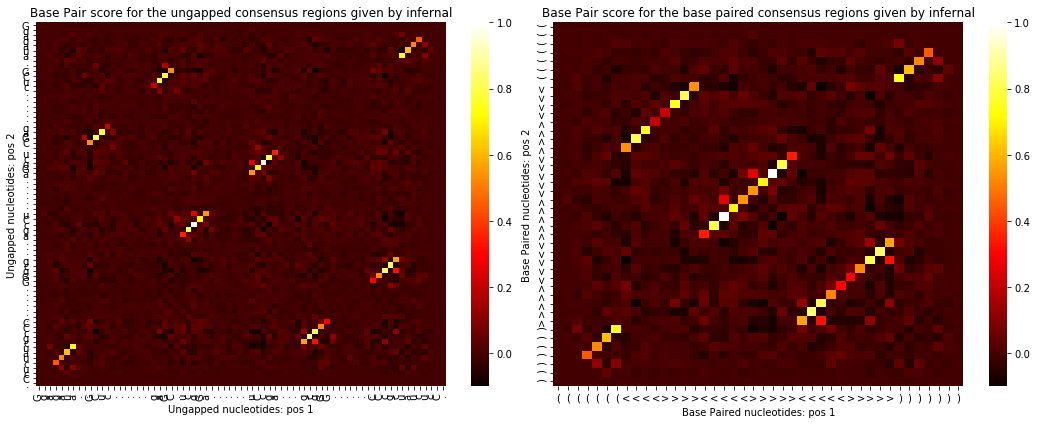

In [126]:
#load values
savepath = 'Arrays/trna_resbindt5_ug_so1000.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1000
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4 matrices
meanhol_mut2 = mean_mut2.reshape(numug,numug,dims,dims)

normalize = True
if normalize:
    meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer, sess, normfactor = 1)
    
    #Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((meanhol_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
C = C - np.mean(C)
C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='hot', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, cmap='hot', linewidth=0.)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show

## Analyse the data

In [1]:
#load values
savepath = 'Arrays/trna_resbind_o_1k.npy'
mean_mut2 = np.load(savepath)

#average the values
num_summary = 1000

#Reshape into a holistic tensor organizing the mutations into 4*4 matrices
meanhol_mut2 = mean_mut2.reshape(numug,numug,dims,dims)

NameError: name 'np' is not defined

In [42]:
#normalize the holistic mutation scores
#WT_mean = np.mean(nntrainer.get_activations(sess, test, layer='dense_1_bias')[plot_index[:500]])

normalize = True
if normalize:
    meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer=0, sess=0, normfactor = 1)

### Watson Crick Filter

In [43]:
def APC_hol(hol):
    cor_hol = np.zeros_like(hol)
    wid = len(hol)
    
    w_hat = np.mean(hol)
    for r in range(wid):
        for c in range(wid):
            cor_hol[r,c] = hol[r,c] - np.mean(hol[r,:])*np.mean(hol[:,c])/w_hat
    
    return (cor_hol)

<function matplotlib.pyplot.show>

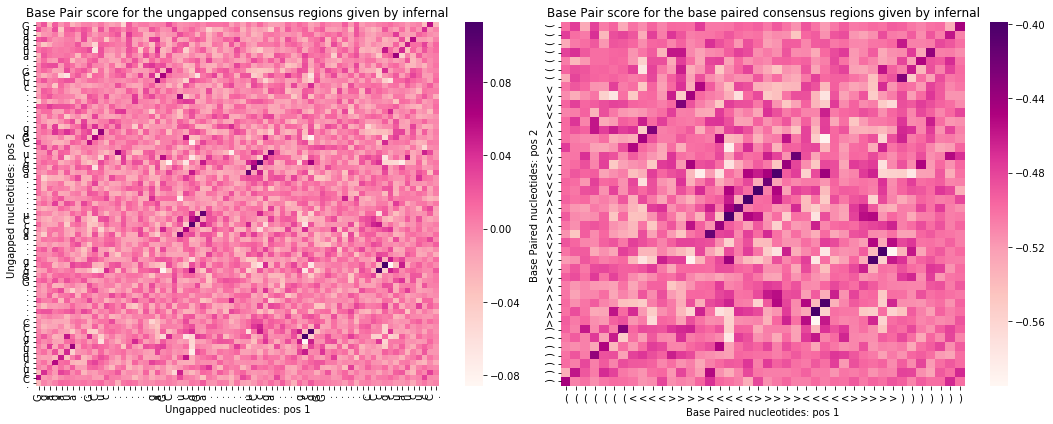

In [44]:
#Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((meanhol_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
#C = C - np.mean(C)
#C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(APC_hol(C), xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, cmap='RdPu', linewidth=0.)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show

### KL divergence

In [45]:
def KLD(hol, ref):
    S = np.ravel(hol)
    R = np.ravel(ref)
    dkl = np.sum([S[i]*(np.log(S[i]+1e-15)-np.log(R[i]+1e-15)) for i in range(len(S))])
    return (dkl)

def KLD_hol(hol_mut, ref):
    KLD_scores = np.zeros((hol_mut.shape[0], hol_mut.shape[0]))
    for one in range(hol_mut.shape[0]):
        for two in range(hol_mut.shape[0]):
            KLD_scores[one, two] = KLD(makeprob(hol_mut[one, two]), ref)
    return (KLD_scores)

def makeprob(hol):
    norm = np.sum(np.abs(hol))
    return (hol/norm)

bpfilter = np.ones((4,4))*0
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 0.25

<function matplotlib.pyplot.show>

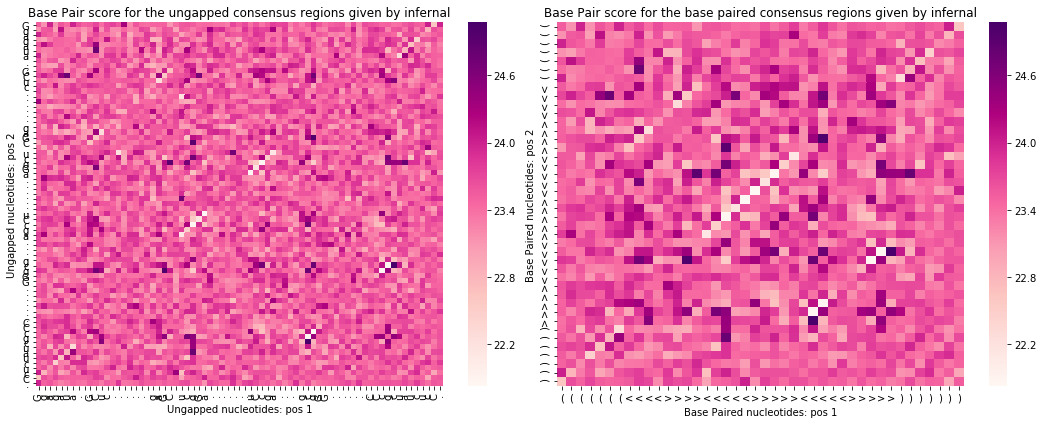

In [46]:
K = KLD_hol(meanhol_mut2, bpfilter)


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(K, xticklabels=bpugSQ, yticklabels=bpugSQ, vmax=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(K[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmax=None, cmap='RdPu', linewidth=0.)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show

### True Base Pairs as comparison

In [47]:
#Get the base pair coords
bp_rc = bp_coords(ugSS)

#make sure that these are what we expect
s = np.zeros_like(K)

for r in bp_rc:
    s[r[0], r[1]] = 1

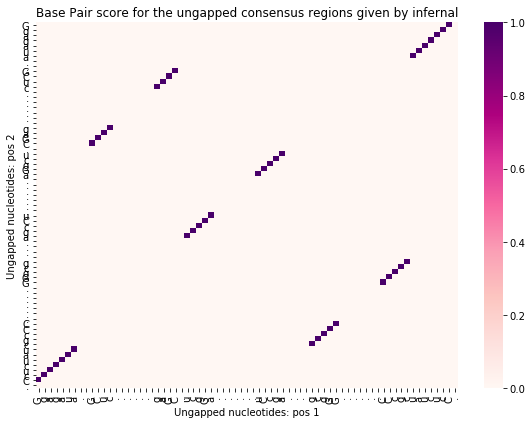

In [48]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(s, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')

In [49]:
#pull out the base pairs from the holistic scores array
bp_hols = np.zeros((numbp, dims, dims))
  
for i,r in enumerate(bp_rc):
    bp_hols[i] = meanhol_mut2[r[0],r[1]]

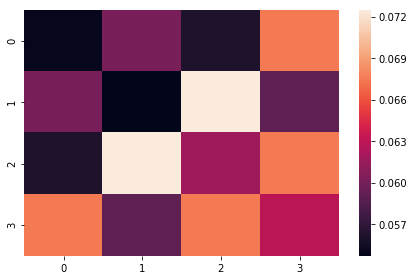

In [50]:
bp_hols_avg = np.mean(bp_hols, axis=0)
plt.figure()
sb.heatmap(makeprob(bp_hols_avg))

In [51]:
bp_hols_avg.sum()

0.9999999884693396

<function matplotlib.pyplot.show>

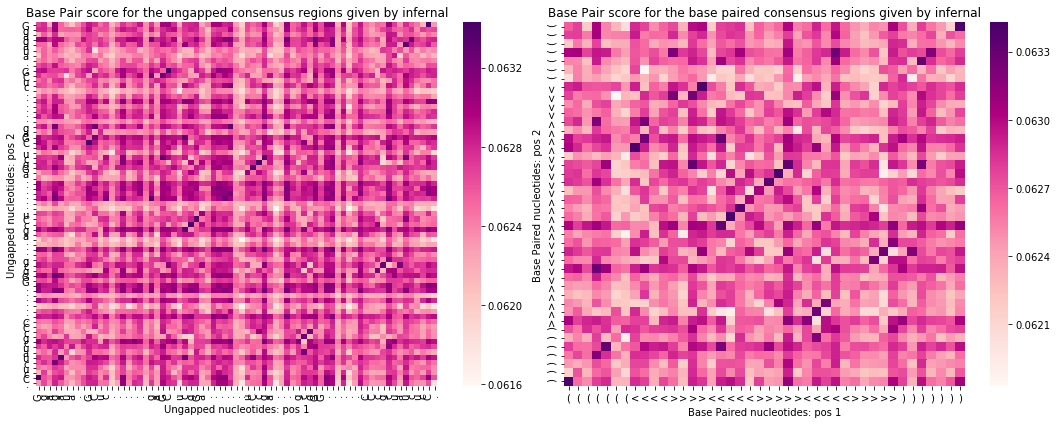

In [52]:
C = np.sum((meanhol_mut2*bp_hols_avg).reshape(numug,numug,dims*dims), axis=2)
#C = C - np.mean(C)
#C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, cmap='RdPu', linewidth=0.)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show

<function matplotlib.pyplot.show>

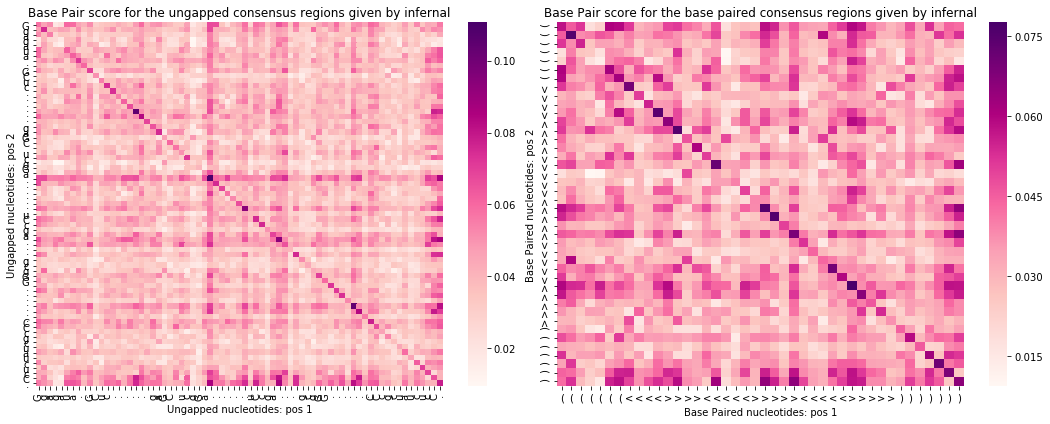

In [53]:
K = KLD_hol(meanhol_mut2, makeprob(bp_hols_avg))


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(K, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(K[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, cmap='RdPu', linewidth=0.)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show

<function matplotlib.pyplot.show>

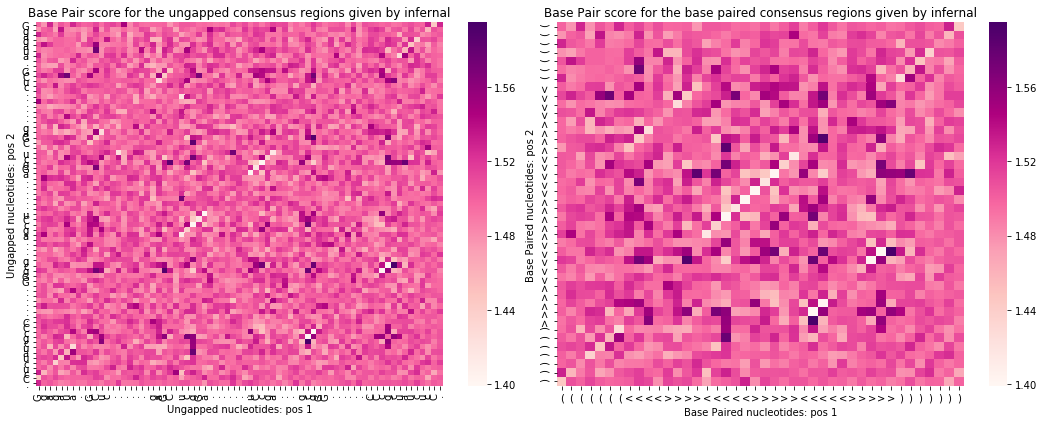

In [54]:
def stupid(hol_mut, ref):
    stu_scores = np.zeros((hol_mut.shape[0], hol_mut.shape[0]))
    for one in range(hol_mut.shape[0]):
        for two in range(hol_mut.shape[0]):
            stu_scores[one, two] = np.sum(np.abs(hol_mut[one, two] -  ref))
    return (stu_scores)

T = stupid(meanhol_mut2, bpfilter)


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(T, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(T[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, cmap='RdPu', linewidth=0.)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show